# Identifying the best individual classification for a galaxy

Which volunteer's model was the best?

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import json
import pandas as pd
from copy import deepcopy
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
import lib.galaxy_utilities as gu
import lib.python_model_renderer.render_galaxy as rg
import lib.python_model_renderer.parse_annotation as pa

In [3]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [4]:
plt.style.use('seaborn-dark')

In [5]:
subject_id = 21096935

Grab required ancilliaries & medatada

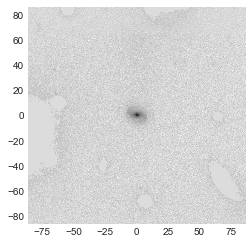

In [6]:
gal, angle = gu.get_galaxy_and_angle(subject_id)
pic_array, deprojected_image = gu.get_image(gal, subject_id, angle)
psf = gu.get_psf(subject_id)
diff_data = gu.get_image_data(subject_id)
pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
galaxy_data = np.array(diff_data['imageData'])[::-1]
size_diff = diff_data['width'] / diff_data['imageWidth']
# arcseconds per pixel for zooniverse image
pix_size = pic_array.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4)
# arcseconds per pixel for galaxy data
pix_size2 = galaxy_data.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4)

imshow_kwargs = {
    'cmap': 'gray_r', 'origin': 'lower',
    'extent': (
        # left of image in arcseconds from centre
        -pic_array.shape[0]/2 / pix_size,
        pic_array.shape[0]/2 / pix_size,  # right...
        -pic_array.shape[1]/2 / pix_size,  # bottom...
        pic_array.shape[1]/2 / pix_size  # top...
    ),
}
plt.imshow(pic_array, **imshow_kwargs)

In [7]:
classifications = gu.classifications.query(
    'subject_ids == {}'.format(subject_id)
)
annotations = classifications['annotations'].apply(json.loads)
models = annotations.apply(pa.parse_annotation, size_diff=size_diff)
%time rendered_models = models.apply(rg.calculate_model, args=(diff_data['width'],))

CPU times: user 39.6 s, sys: 2.1 s, total: 41.7 s
Wall time: 41.2 s


Note we aren't going off of the score shown to volunteers, which arcsinh scaled the image after subtracting residuals.

In [8]:
residuals = rendered_models.apply(
    lambda arr: (
        0.8 * galaxy_data
        - rg.convolve2d(arr, psf, mode='same', boundary='symm')
    )
)
masked_residuals = residuals.apply(lambda v: pixel_mask * v)

In [9]:
def _lf(rendered_model, y=galaxy_data, loss_function=r2_score):
    Y = rg.convolve2d(rendered_model, psf, mode='same', boundary='symm') * pixel_mask
    return loss_function(Y.flatten(), 0.8 * (y * pixel_mask).flatten())

idxes = (
  rendered_models.apply(_lf, loss_function=mean_squared_error).idxmin(),
  rendered_models.apply(_lf, loss_function=median_absolute_error).idxmin(),
  rendered_models.apply(_lf, loss_function=r2_score).idxmax(),
)
idxes

(2466, 2466, 9955)

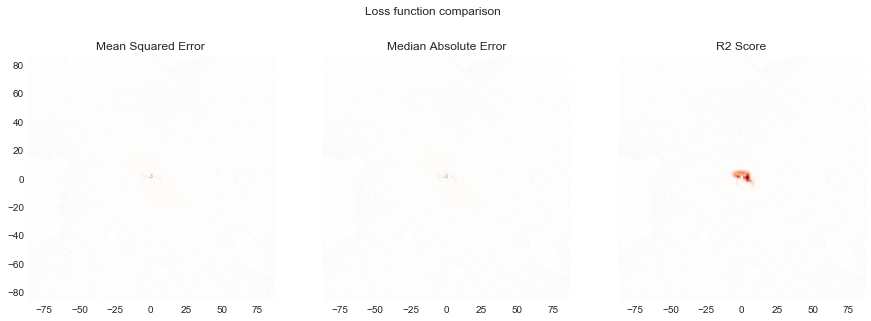

In [10]:
m = np.abs(
    np.dstack([masked_residuals.loc[i] for i in idxes])
).max()
k = {**imshow_kwargs, 'vmin': -m, 'vmax': m, 'cmap': 'RdGy'}
fig, ax = plt.subplots(ncols=3, figsize=(15, 5), sharex=True, sharey=True)

ax[0].imshow(masked_residuals.loc[idxes[0]], **k)
ax[0].set_title('Mean Squared Error')
ax[1].imshow(masked_residuals.loc[idxes[1]], **k)
ax[1].set_title('Median Absolute Error')
ax[2].imshow(masked_residuals.loc[idxes[2]], **k)
ax[2].set_title('R2 Score')
plt.suptitle('Loss function comparison');

In [11]:
scores = rendered_models.apply(_lf, loss_function=mean_squared_error)
best_index = scores.idxmin()
best_cls = classifications.loc[best_index]

In [12]:
best_cls

classification_id                                            106591673
user_name                           not-logged-in-7293e12da8eb5881cfe1
user_id                                                            NaN
user_ip                                           7293e12da8eb5881cfe1
workflow_id                                                       5366
workflow_name                                  Main modelling workflow
workflow_version                                                61.107
created_at                                     2018-05-07 19:06:31 UTC
gold_standard                                                      NaN
expert                                                             NaN
metadata             {"session":"b47966763e1eed8490b366c0f77e8d1168...
annotations          [{"task":"disk","task_label":null,"value":[{"t...
subject_data         {"21096935":{"retired":{"id":14554915,"workflo...
subject_ids                                                   21096935
Name: 

This method has been written into a python function, and can be run over all galaxies. The function takes approximately 10 seconds per galaxy, which is not great but not unmanageable.

In [13]:
from best_individual_classifications import get_best_classification
%time c = get_best_classification(subject_id)

CPU times: user 35.7 s, sys: 2.01 s, total: 37.7 s
Wall time: 37.2 s


In [14]:
c['classification_id'] == best_cls['classification_id']

True

# How far can we go?

Now let's fine tune the sliders to see how good a model we can get. We'll leave the components roll and center fixed, but vary the sliders, the size and the axis ratio.

In [15]:
from model_fitting import Model, ModelFitter

In [16]:
best_model = deepcopy(models.loc[best_index])

In [17]:
mf = ModelFitter(best_model, galaxy_data, psf, pixel_mask)
md = mf.model

We have a lot of parameters, and each model calculation takes a while (~300ms), so a least squares fitter is gonna struggle a bit...

In [18]:
print('number of parameters to fit: {}'.format(len(mf.model.p)))

number of parameters to fit: 12


We'll only run for a few iterations, which will hopefully be enough to see some improvement!

In [19]:
%time new_model, res = mf.fit(options={'maxiter': 50})

CPU times: user 4min 42s, sys: 12.4 s, total: 4min 54s
Wall time: 5min 11s


In [20]:
before_arr = md.render(models.loc[best_index])
after_arr = md.render_from_p(res['x'])
delta = before_arr - after_arr
before_comparison = rg.compare_to_galaxy(
    before_arr, md.psf, md.data, md.pixel_mask
)

after_comparison = rg.compare_to_galaxy(
    after_arr, md.psf, md.data, md.pixel_mask
)

Mean squared error:
	Before: 0.00017948
	After:  0.00017548
GZB scores:
	Before: 76.96387994
	After: 77.40481079


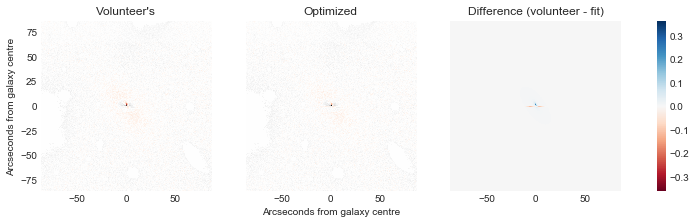

In [21]:
v_extreme = max(np.abs(before_comparison).max(), np.abs(after_comparison).max())
_, ax = plt.subplots(figsize=(13, 5), ncols=3, sharey=True)
plt.sca(ax[0])
plt.imshow(
    before_comparison, vmin=-v_extreme, vmax=v_extreme,
    **{**imshow_kwargs, 'cmap': 'RdGy'}
)
plt.title('Volunteer\'s')
plt.ylabel('Arcseconds from galaxy centre')
plt.sca(ax[1])
plt.imshow(
    after_comparison, vmin=-v_extreme, vmax=v_extreme,
    **{**imshow_kwargs, 'cmap': 'RdGy'}
)
plt.title('Optimized')
plt.xlabel('Arcseconds from galaxy centre')
plt.sca(ax[2])
i = plt.imshow(
    delta, vmin=-np.abs(delta).max(), vmax=np.abs(delta).max(),
    **{**imshow_kwargs, 'cmap': 'RdBu'}
)
plt.colorbar(ax=ax, shrink=0.625)
plt.title('Difference (volunteer - fit)')

print('Mean squared error:')
print('\tBefore: {:.8f}'.format(mf.loss(before_arr)))
print('\tAfter:  {:.8f}'.format(mf.loss(after_arr)))
print('GZB scores:')
print('\tBefore: {:.8f}'.format(
      rg.GZB_score(rg.compare_to_galaxy(before_arr, mf.model.psf, mf.model.data,
                                        mf.model.pixel_mask, stretch=False))
))
print('\tAfter: {:.8f}'.format(
      rg.GZB_score(rg.compare_to_galaxy(after_arr, mf.model.psf, mf.model.data,
                                        mf.model.pixel_mask, stretch=False))
))

In [22]:
m0 = Model(models.loc[best_index], galaxy_data, psf, pixel_mask)
m1 = Model(new_model, galaxy_data, psf, pixel_mask)

In [23]:
c0, s0 = m0.to_df()
c1, s1 = m1.to_df()
c0 - c1

,axRatio,c,i0,mu,n,rEff,roll
disk,-0.012225,0.00000,0.003706,"[0.0, 0.0]",0.000000,-0.000459,-3.141593
bulge,-0.075559,0.00000,0.086222,"[0.0, 0.0]",0.015837,0.004833,0.000000
bar,0.069224,-0.00914,-0.049141,"[0.0, 0.0]",-0.011859,-0.008020,0.000000


In [24]:
s0 - s1

""
Spiral number


In [25]:
from IPython.display import display
display(c1)
display(s1) 

,axRatio,c,i0,mu,n,rEff,roll
disk,0.512225,2.00000,0.026294,"[218.05990600585938, 217.81985473632812]",1.000000,97.848211,0.939717
bulge,0.575559,2.00000,0.393778,"[218.94009399414062, 220.03366088867188]",1.454163,6.037571,1.071450
bar,0.065911,1.96914,0.259141,"[216.37954711914062, 215.33932495117188]",0.341859,2.653919,0.000000


""
Spiral number


In [26]:
gzb_comps = '+'.join(
  i for i, j in zip(('disc', 'bulge', 'bar'), ~np.isnan(c1['axRatio'].values)) if j
)

If we remove the spirals, how do the fitted parameters change? As above, we're leaving the components roll and center fixed, but varying the sliders, the size and the axis ratio

In [27]:
no_spiral_model = deepcopy(models.loc[best_index])
no_spiral_model['spiral'] = []

mf_nosp = ModelFitter(no_spiral_model, galaxy_data, psf, pixel_mask)
md_nosp = mf_nosp.model
# best_model['spiral'] = []
%time new_nosp_model, res = mf_nosp.fit(options={'maxiter': 100})
m0_nosp = Model(no_spiral_model, galaxy_data, psf, pixel_mask)
m1_nosp = Model(new_nosp_model, galaxy_data, psf, pixel_mask)
c0_nosp, _ = m0_nosp.to_df()
c1_nosp, _ = m1_nosp.to_df()

CPU times: user 4min 41s, sys: 12.4 s, total: 4min 53s
Wall time: 5min 4s


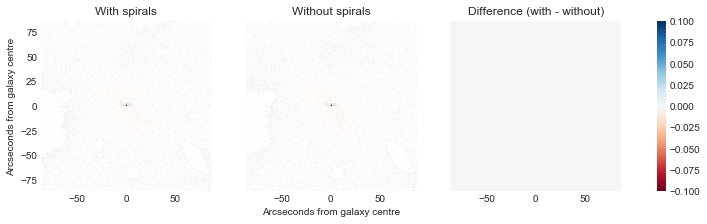

In [28]:
nosp_arr = md_nosp.render(new_nosp_model)
nosp_comparison = rg.compare_to_galaxy(
    nosp_arr, md_nosp.psf, md_nosp.data, md_nosp.pixel_mask
)
v_extreme2 = max(np.abs(after_comparison).max(), np.abs(nosp_comparison).max())
_, ax = plt.subplots(figsize=(13, 5), ncols=3, sharey=True)
plt.sca(ax[0])
plt.imshow(
    after_comparison, vmin=-v_extreme2, vmax=v_extreme2,
    **{**imshow_kwargs, 'cmap': 'RdGy'}
)
plt.title('With spirals')
plt.ylabel('Arcseconds from galaxy centre')
plt.sca(ax[1])
plt.imshow(
    nosp_comparison, vmin=-v_extreme2, vmax=v_extreme2,
    **{**imshow_kwargs, 'cmap': 'RdGy'}
)
plt.title('Without spirals')
plt.xlabel('Arcseconds from galaxy centre')
plt.sca(ax[2])
delta2 = after_arr - nosp_arr
i = plt.imshow(
    delta2, vmin=-np.abs(delta2).max(), vmax=np.abs(delta2).max(),
    **{**imshow_kwargs, 'cmap': 'RdBu'}
)
plt.colorbar(ax=ax, shrink=0.625)
plt.title('Difference (with - without)');

In [29]:
print('Mean squared error:')
print('\tWith spirals:    {:.8f}'.format(mf.loss(after_arr)))
print('\tWithout spirals: {:.8f}'.format(mf.loss(nosp_arr)))
print('GZB scores:')
print('\tWith spirals:    {:.8f}'.format(
      rg.GZB_score(rg.compare_to_galaxy(after_arr, mf.model.psf, mf.model.data,
                                        mf.model.pixel_mask, stretch=False))
))
print('\tWithout spirals: {:.8f}'.format(
      rg.GZB_score(rg.compare_to_galaxy(nosp_arr, mf.model.psf, mf.model.data,
                                        mf.model.pixel_mask, stretch=False))
))

Mean squared error:
	With spirals:    0.00017548
	Without spirals: 0.00017548
GZB scores:
	With spirals:    77.40481079
	Without spirals: 77.40481079
